In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../'))
sys.path.insert(0, os.path.abspath('/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/'))
sys.path.insert(0, os.path.abspath('/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/ibm/'))

In [2]:
import numpy as np

import qiskit
provider = qiskit.IBMQ.load_account()
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import QAOA
from shared.QiskitMaxcut import *
from ibm.ibm_parameters import *

from matplotlib import pyplot as plt
%matplotlib inline

graph_05_06_02


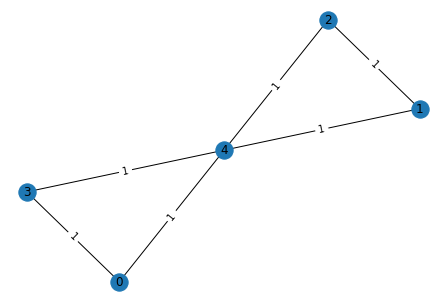

In [3]:
graph = generate_butterfly_graph(with_weights=False)
max_cut = Maxcut(graph)
max_cut_qubo = max_cut.to_qubo()
print(graph.name)
max_cut.draw()

In [5]:
step_size = 0.1
a_gamma = np.arange(0, np.pi, step_size)
b_beta = np.arange(0, np.pi, step_size)

In [6]:
a_gamma, b_beta = np.meshgrid(a_gamma, b_beta)
len(a_gamma)

32

In [7]:
quantum_instance = QuantumInstance(
                    backend=Aer.get_backend(DEFAULT_QASM_SIMULATOR),
                    shots=SHOTS)
qaoa = QAOA(
            optimizer=COBYLA(maxiter=0),
            quantum_instance=quantum_instance,
            reps=1
            )

op, offset = max_cut_qubo.to_ising()

In [8]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

In [9]:
def create_cirucit(gamma,beta):
    circuits = qaoa.construct_circuit([gamma,beta], operator=op)
    circuit = circuits[0]
    circuit.measure_all()
    return circuit

In [21]:
landscape = np.zeros(a_gamma.shape)

for i in range(0, len(landscape)):
    circuits = []
    for j in range(0, len(landscape)):
        # create circuits for entire row 
        circuit = create_cirucit(a_gamma[i][j], b_beta[i][j])
        circuits.append(circuit)
    
    # create one job with circuits 
    job_name = f"{graph.name}_row_{i}"
    job = quantum_instance.execute(circuits)
    #job.update_name(job_name)
    print(job_name)
    #print(job)
    
    # add results to landscape 
    j = 0
    for count in job.get_counts():
        mean = compute_expectation(count, graph)
        landscape[i,j] = mean
        j += 1

graph_05_06_02_row_0
graph_05_06_02_row_1
graph_05_06_02_row_2
graph_05_06_02_row_3


[[-2.99875 -2.9815  -2.98475 -3.00225]
 [-2.98875 -2.69275 -2.054   -2.774  ]
 [-3.026   -1.95425 -2.958   -3.16375]
 [-3.0195  -3.20175 -2.68325 -2.89075]]


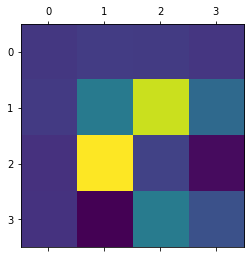

In [20]:
print(landscape)
plt.matshow(landscape)
plt.show()

In [10]:
landscape = np.load('landscape_mumbai_butterfly_no_weights_results.npy')

In [11]:
# Mean of landscape
np.mean(landscape)

-2.805593017578125

In [12]:
# Minimium 
np.min(landscape)

-3.3245

In [13]:
# Display Coordinates of Minimum 
np.unravel_index(np.argmin(landscape), landscape.shape)

(23, 18)

In [14]:
# Gamma and beta value of Minimium
gamma, beta = np.unravel_index(np.argmin(landscape), landscape.shape)
opt_gamma = gamma * step_size
opt_beta = beta * step_size
print(f"Opt.Gamma: {opt_gamma}, Opt.Beta: {opt_beta}")

Opt.Gamma: 2.3000000000000003, Opt.Beta: 1.8


In [15]:
# Save result matrix 
#with open('landscape_mumbai_butterfly_no_weights_results.npy', 'wb') as f:
#    np.save(f, landscape)

In [16]:
import plotly.graph_objects as go

In [23]:
# Plot landscape in 3D 
a_gamma = np.arange(0, np.pi, step_size)
b_beta = np.arange(0, np.pi, step_size)
fig = go.Figure(data=go.Surface(z=landscape, x=a_gamma, y=b_beta))

fig.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor='limegreen', project_z=True))


fig.update_layout(title="QAOA without Error Mitigation - MaxCut-Landscape", scene=dict(
    xaxis_title="γ",
    yaxis_title="β",
    zaxis_title="F(γ,β)"
))

In [24]:
# Plot Heatmap 
fig = go.Figure(data=go.Heatmap(z=landscape, y=b_beta, x=a_gamma, type = 'heatmap', colorscale = 'viridis'))

# Update Layout
fig.update_layout(title="F(γ,β)", width=700, height=700, yaxis_title="β", xaxis_title="γ")

# Display Global Minimium 
fig.add_trace(
    go.Scatter(mode="markers", x=[opt_beta], y=[opt_gamma], marker_symbol=[204], text = [landscape[gamma,beta]],
                   marker_color="red",  hovertemplate="x: %{x}<br>y: %{y}<br> z: %{text:.2f}<extra></extra>", 
                   marker_line_width=1, marker_size=16))

In [ ]:
# Display Optimizer Results

# Display path 
#fig.add_trace(
#    go.Scatter(mode="lines", x=gammas, y=betas, marker_symbol=[200],
#                   marker_color="white", marker_line_width=1, marker_size=8)
#)

# Display start point
#fig.add_trace(
#    go.Scatter(mode="markers", x=[gammas[0]], y=[betas[0]], marker_symbol=[204],
#                   marker_color="gray", 
#                   marker_line_width=1, marker_size=16))

# Display end point
#fig.add_trace(
#    go.Scatter(mode="markers", x=[gammas[-1]], y=[betas[-1]], marker_symbol=[204],
#                   marker_color="green", 
#                   marker_line_width=1, marker_size=16))



In [ ]:
# Plot Optimizer History
#fig = go.Figure(data=go.Scatter(x=counts, y=values))
#fig.update_layout(xaxis_title="Evaluation Counts", yaxis_title="Evaluated Mean", title="Optimizer")
#fig.show()